In [53]:
from __future__ import print_function
from __future__ import absolute_import
from ku import generators as gr
from ku import generic as gen
from ku import image_utils as iu
from ku import image_augmenter as ia
from munch import Munch
import pandas as pd, numpy as np
import pytest
import matplotlib.pyplot as plt

In [2]:
gen_params = Munch(batch_size    = 2,
                   data_path     = 'images',
                   input_shape   = (224,224,3),
                   inputs        = ['filename'],
                   outputs       = ['score'],
                   shuffle       = False,
                   fixed_batches = True)

ids = pd.read_csv(u'ids.csv', encoding='latin-1')

np.all(ids.columns == ['filename', 'score'])
np.all(ids.score == range(1,5))

True

In [3]:
g = gr.DataGeneratorDisk(ids, **gen_params)
print(isinstance(g[0][1], list))
print(np.all(g[0][1][0] == np.array([[1],[2]])))

gen.get_sizes(g[0])=='([array<2,224,224,3>], [array<2,1>])'

True
True


True

In [4]:
read_fn = lambda p: iu.resize_image(iu.read_image(p), (100,100))
g = gr.DataGeneratorDisk(ids, read_fn=read_fn, **gen_params)
gen.get_sizes(g[0]) =='([array<2,100,100,3>], [array<2,1>])'

True

In [5]:
# reload(gen)
x = np.array([[1,2,3]])
print(gen.get_sizes(([x.T],1,[4,5])))
y = np.array([[1,[1,2]]])
print(gen.get_sizes(y))
z = [g[0],([2],)]
print(gen.get_sizes(z[1]))

([array<3,1>], <1>, [<1>, <1>])
array<1,2>
([<1>])


In [6]:
gen_params.inputs = ['filename', 'filename']
g = gr.DataGeneratorDisk(ids, **gen_params)
assert gen.get_sizes(g[0]) == '([array<2,224,224,3>, array<2,224,224,3>], [array<2,1>])'

g.inputs_df = ['score', 'score']
g.inputs = []
g.outputs = []
gen.get_sizes(g[0])

g.inputs_df = [['score'], ('score','score')]
assert gen.get_sizes(g[0]) == '([array<2,1>, array<2,2>], [])'

g.inputs_df = []
g.outputs = ['score']
assert gen.get_sizes(g[0]) == '([], [array<2,1>])'

g.outputs = ['score',['score']]
with pytest.raises(AssertionError): g[0]

g.outputs = [['score'],['score']]
assert gen.get_sizes(g[0]) == '([], [array<2,1>, array<2,1>])'

In [7]:
with gen.H5Helper('data.h5', over_write=True) as h:
    data = np.expand_dims(np.array(ids.score), 1)
    h.write_data(data, list(ids.filename))

with gen.H5Helper('data.h5', 'r') as h:
    data = h.read_data(list(ids.filename))
    assert all(data == np.array([[1],[2],[3],[4]]))

In [8]:
gen_params.update(data_path='data.h5', 
                  inputs=['filename'],
                  batch_size=2)
gen.pretty(gen_params)
g = gr.DataGeneratorHDF5(ids, **gen_params)
assert gen.get_sizes(g[0]) == '([array<2,1>], [array<2,1>])'

g.inputs_df = ['score', 'score']
g.inputs = []
g.outputs = []
assert gen.get_sizes(g[0]) == '([array<2,2>], [])'

g.inputs_df = [['score'], ('score','score')]
assert gen.get_sizes(g[0]) == '([array<2,1>, array<2,2>], [])'

g.inputs_df = []
g.outputs = ['score']
assert gen.get_sizes(g[0]) == '([], [array<2,1>])'

g.outputs = ['score',['score']]
with pytest.raises(AssertionError): g[0]

g.outputs = [['score'],['score']]
assert gen.get_sizes(g[0]) == '([], [array<2,1>, array<2,1>])'

batch_size:    2
data_path:     data.h5
input_shape:   (224, 224, 3)
inputs:        ['filename']
outputs:       ['score']
shuffle:       False
fixed_batches: True


In [9]:
d = {'features': [1, 2, 3, 4, 5], 'mask': [1, 0, 1, 1, 0]}
df = pd.DataFrame(data=d)

def filter_features(df):
    return np.array(df.loc[df['mask']==1,['features']])

gen_params.update(data_path = None, 
                  outputs   = filter_features,
                  inputs    = [],
                  inputs_df = ['features'],
                  shuffle   = False,
                  batch_size= 5)
# gen.pretty(gen_params)

g = gr.DataGeneratorHDF5(df, **gen_params)
assert gen.get_sizes(g[0]) == '([array<5,1>], array<3,1>)'
assert all(np.squeeze(g[0][0]) == np.arange(1,6))
assert all(np.squeeze(g[0][1]) == [1,3,4])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


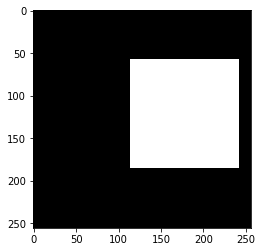

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


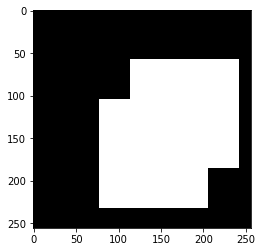

In [79]:
m = np.zeros((5,5,3))
c = np.zeros((5,5,3))
c[1:4,1:4,:] = 255

assert np.array_equal(iu.cropout_patch(m, patch_size=(3,3), patch_position=(0.5,0.5), fill_val=255), c)

m = np.zeros((256,256,3))
plt.imshow(iu.cropout_random_patch(m.copy(), patch_size=(128,128), fill_val=255))
plt.show()
plt.imshow(iu.cropout_random_patch(m.copy(), patch_size=(128,128), fill_val=255))
plt.show()

In [45]:
!pytest -v --verbosity 3

/bin/sh: 1: pytest: not found
